In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib
import bnpgmm_runjingdev.hessian_lib as hessian_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Load data

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

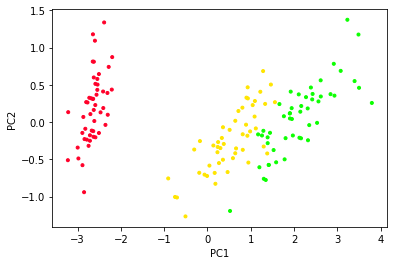

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [6]:
k_approx = 30

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1459.0115663552124

## Initialize 

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

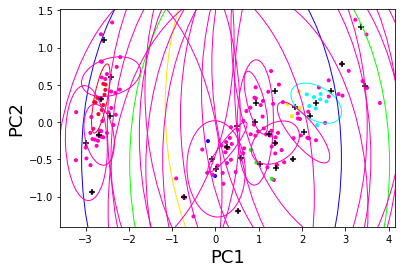

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [13]:
vb_opt_dict, e_z_opt = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 266
stick_time: 1.401sec
cluster_time: 0.119sec
e_z_time: 0.345sec
**TOTAL time: 4.251sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.00777sec


In [18]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.0442sec


In [19]:
# if its impossible, don't run the hessian
run_hessian = True

In [20]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 14.7sec


In [21]:
t0 = time.time()
x = vb_opt
hvp = obj_fun_hvp(vb_opt, prior_params_free, x)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.0964sec


In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 4.28sec


# Solver times

### Solver without preconditioning

In [24]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.0014sec


In [25]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
_ = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 9.04sec


### Solver with mfvb preconditioner

In [26]:
t0 = time.time()
mfvb_preconditioner = preconditioner_lib.get_gmm_preconditioner(vb_opt, vb_params_paragami)
print('precond. time: {:0.3}sec'.format(time.time() - t0))

precond. time: 1.31sec


In [27]:
cg_solver_mfvb_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner})
    
t0 = time.time()
_ = -cg_solver_mfvb_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 5.4sec


### Nystrom woodbury preconditioner

In [28]:
# nystrom woodbury preconditioner : compute with block hessian
# get k - largest clusters

t0 = time.time()
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

sub_block_hess, indx = hessian_lib.get_large_clusters_hessian(features, which_k, vb_opt, vb_params_paragami, 
                                                                  prior_params_dict, gh_loc, gh_weights)

est_lambda_max = np.abs(sub_block_hess).sum(1).max()
nystrom_precond = preconditioner_lib.get_nystrom_woodbury_precon(sub_block_hess, indx, est_lambda_max)

print('nystrom precontime time: ', time.time() - t0)

nystrom precontime time:  1.959777593612671


In [29]:
cg_solver_nystrom_precond = \
    vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond})
    
t0 = time.time()
_ = -cg_solver_nystrom_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 4.3sec


In [30]:
# get woodbury-nystrom preconditioner : use full Hessian 
lambda_max = np.max(np.linalg.eigvals(hess)) 
print(lambda_max)
print(est_lambda_max)

nystrom_precond2 = preconditioner_lib.get_nystrom_woodbury_precon(hess, indx, est_lambda_max)


2451.1259105527097
3307.890091812522


In [31]:
cg_solver_nystrom_precond2 = \
    vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond2})
    
t0 = time.time()
_ = -cg_solver_nystrom_precond2(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 3.53sec


# Lets look at the CG solver in more detail 

### Check out optimization path

In [32]:
class CGCallback(): 
    def __init__(self, mat_times_vec, b): 
        self.mat_times_vec = mat_times_vec
        self.b = b
        
        self.residuals = []
        
    def record_residuals(self, x): 
        self.residuals.append(np.linalg.norm(-x - dinput_dhyper[:, 0]))
        
    def return_path(self): 
        return np.array(self.residuals)

In [33]:
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
b = cross_hess[:, 0]
cg_callback = CGCallback(mat_times_vec, b)

x0 = mfvb_preconditioner.dot(b)

In [34]:
# no preconditioner
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path1 = cg_callback.return_path()

solver time: 10.2sec


In [35]:
# mfvb preconditioner
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path2 = cg_callback.return_path()

solver time: 4.65sec


In [36]:
# nystrom with block hessian
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path3 = cg_callback.return_path()

solver time: 4.27sec


In [ ]:
# nystrom with full hessian
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond2, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path4 = cg_callback.return_path()

In [ ]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', linestyle = '--', label = 'cg-precond-nystrom_wood2')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')